In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [2]:
rng = np.random.default_rng(42)

std = 0.2
cls_0 = np.array([0, -1]) + rng.normal(size=(100, 2))*std
cls_1 = np.array([1, 0]) + rng.normal(size=(100, 2))*std
cls_2 = np.array([0, 1]) + rng.normal(size=(100, 2))*std
cls_3 = np.array([-1, 0]) + rng.normal(size=(100, 2))*std
cls_4 = np.tile([[0, -1], [1, 0]], [50, 1]) + rng.normal(size=(100, 2))*std
cls_5 = np.tile([[0, 1], [1, 0]], [50, 1]) + rng.normal(size=(100, 2))*std
X = np.concatenate([cls_0, cls_1, cls_2, cls_3, cls_4, cls_5], axis=0)
y = np.tile(np.arange(6), [100, 1]).T.ravel()

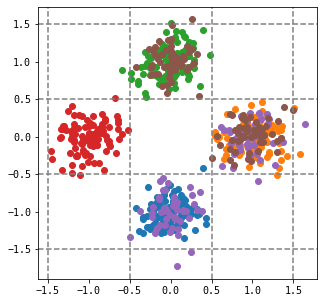

In [3]:
plt.figure(figsize=(5, 5))
for c in range(6):
    plt.scatter(*X[y==c].T, c=f'C{c}')
for i in np.arange(-1.5, 2.5):
    plt.gca().axvline(x=i, ymin=0, ymax=1, color=(0.5, 0.5, 0.5), linestyle='--')
    plt.gca().axhline(y=i, xmin=0, xmax=1, color=(0.5, 0.5, 0.5), linestyle='--')
plt.show(); plt.close()

In [5]:
from scipy.spatial import distance_matrix

voxels = np.unique(np.round(X), axis=0)
X_voxel = np.empty(X.shape[0:1])
for i, v in enumerate(voxels):
    X_voxel[(np.round(X) == v).all(axis=1)] = i
d2_matrix = np.square(distance_matrix(voxels, voxels))

distribs = np.empty((6, voxels.shape[0]))
for c in range(6):
    for i in range(voxels.shape[0]):
        distribs[c, i] = np.sum((X_voxel == i) & (y == c))
distribs /= np.sum(distribs, axis=1, keepdims=True)

In [188]:
import itertools

def get_var(distribs):
    return np.ones(distribs.shape[:-1]) - np.sum(np.square(distribs), axis=-1)

def get_prop_index(distribs_1, distribs_2=None):
    if distribs_2 is None:
        distribs_2 = distribs_1
    prop_indices = np.zeros((len(distribs_1), len(distribs_2)))
    for (i, distrib_1), (j, distrib_2) in itertools.product(enumerate(distribs_1), enumerate(distribs_2)):
        prop_indices[i, j] = np.min(np.divide(
            distrib_2, distrib_1,
            out=np.full_like(distrib_1, np.infty),
            where=(distrib_1 > 0)
        ))
    return prop_indices

def get_canonical_path(distrib_1, distrib_2):
    proba_ratio = np.divide(
        distrib_1, distrib_2, 
        out=np.full_like(distrib_1, np.infty), where=(distrib_2 > 0))
    index_order = np.argsort(proba_ratio)
    vertices = []
    p_coef = 1
    q_coef = 0
    t_intersect = 1; s_intersect = 0
    for idx in index_order:
        p_coef_nxt = p_coef - distrib_1[idx]
        q_coef_nxt = q_coef + distrib_2[idx]
        if (distrib_1[idx] != 0) or (distrib_2[idx] != 0):
            t_intersect = (q_coef_nxt - q_coef) / (q_coef_nxt*p_coef-q_coef*p_coef_nxt)
            s_intersect = (p_coef_nxt - p_coef) / (p_coef_nxt*q_coef-p_coef*q_coef_nxt)
        vertex = np.where(proba_ratio >= proba_ratio[idx], distrib_1*t_intersect, distrib_2*s_intersect)
        vertices.append( vertex )

        p_coef = p_coef_nxt; q_coef = q_coef_nxt
    return np.array(vertices)

def get_canonical_parent(vertices):
    result = vertices[0]
    for i in range(1, vertices.shape[0]):
        v_prv, v_nxt = vertices[i-1], vertices[i]
        if (v_prv == v_nxt).all():
            continue
        t_opt = (v_prv @ (v_prv - v_nxt))/np.sum(np.square(v_nxt-v_prv))
        if t_opt < 0:
            v_opt = v_prv
            continue
        elif t_opt > 1:
            v_opt = v_nxt
        else:
            v_opt = (1-t_opt)*v_prv + t_opt*v_nxt
        if get_var(result) <= get_var(v_opt):
            result = v_opt
    return result

def get_hierarchy(distribs, tol=1e-1):
    prop_indices = get_prop_index(distribs)
    quivers = []
    similar_pairs = []
    for (i, distrib_i), (j, distrib_j) in itertools.combinations(enumerate(distribs), 2):
        if i >= j: continue
        p_ij = prop_indices[i, j]; p_ji = prop_indices[j, i]
        if (p_ij < tol) and (p_ji < tol):
            parent = get_canonical_parent(
                get_canonical_path(distrib_i, distrib_j)
            )
            prop_temp = get_prop_index([distrib_i, distrib_j], [parent])
            if (prop_temp < 1-tol).all(): continue
            elif prop_temp[0, 0] >= 1-tol:
                p_ij = get_prop_index([parent], [distrib_j])[0, 0]
                p_ji = prop_temp[1, 0]
            elif prop_temp[1, 0] >= 1-tol:
                p_ij = prop_temp[0, 0]
                p_ji = get_prop_index([parent], [distrib_i])[0, 0]
        if (p_ij < tol) and (p_ji < tol):
            continue
        elif (p_ij >= tol) and (p_ji >= tol):
            similar_pairs.append( (i, j) )
        elif (p_ij < tol) and (p_ji >= tol):
            quivers.append( (j, i) )
        elif (p_ij >= tol) and (p_ji <= tol):
            quivers.append( (i, j) )
    return quivers, similar_pairs, get_var(distribs)

In [183]:
from scipy.optimize import minimize, LinearConstraint
from scipy.spatial import distance_matrix
from collections import defaultdict

def draw_hierarchy(hierarchy_data, ax=None):
    def _potential(x, y):
        pts = np.stack([x, y], axis=1)
        return np.sum(np.reciprocal(
            distance_matrix(pts, pts), 
            out=np.zeros((pts.shape[0], pts.shape[0])), 
            where=(1!=np.eye(pts.shape[0]))
        ))
    def _search_indirect_path(from_, to_, lookup, direct=False):
        if direct and to_ in lookup.get(from_, set()):
            return True
        for mid_ in lookup.get(from_, set()):
            if _search_indirect_path(mid_, to_, lookup, direct=True):
                return True
        return False

    quivers, similar_pairs, variations = hierarchy_data
    descendents = defaultdict(set)
    immediate_quivers = []
    for from_, to_ in quivers:
        descendents[from_].add(to_)
    for from_, to_ in quivers:
        if not _search_indirect_path(from_, to_, descendents):
            immediate_quivers.append( (from_, to_))
    immediate_quivers = np.array(immediate_quivers).T

    y = 1 / (1-variations)
    res = minimize(
        _potential, np.linspace(np.min(y), np.max(y), len(y)), 
        args=y,
        constraints=LinearConstraint(
            np.eye(y.shape[0]), 
            lb=np.min(y), 
            ub=np.max(y)
        )
    )
    if ax is None: ax = plt.gca()
    nodes = np.stack([res.x, y], axis=1)
    ax.scatter(*nodes.T, s=64)
    for i, node in enumerate(nodes):
        ax.text(*node, f'class {i}')
    ax.quiver(
        *nodes[immediate_quivers[0]].T, 
        *(nodes[immediate_quivers[1]]-nodes[immediate_quivers[0]]).T,
        angles='xy',
        scale=1,
        scale_units='xy',
        width=0.005,
        headwidth=8,
        headlength=20,
        headaxislength=16,
    )
    ax.set_xticks([])
    ax.grid()

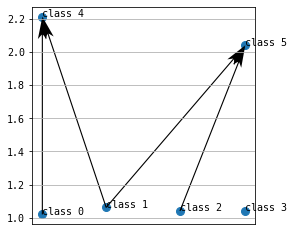

In [189]:
plt.figure(figsize=(4, 4))
draw_hierarchy(
    get_hierarchy(distribs, tol=2e-1)
)
plt.show(); plt.close()

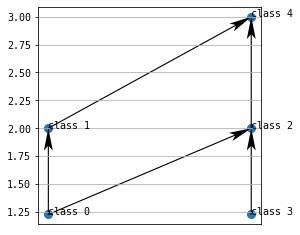

In [184]:
plt.figure(figsize=(4, 4))
draw_hierarchy(
    get_hierarchy(np.array([
        [1/20, 18/20, 1/20], 
        [1/2, 1/2, 0], 
        [0, 1/2, 1/2], 
        [1/20, 1/20, 18/20],
        [1/3, 1/3, 1/3]
    ]), tol=2e-1)
)
plt.show(); plt.close()

In [102]:
def get_var(distribs, nodes=None):
    if nodes is None:
        nodes = np.eye(distribs.shape[1])
    mass_center = np.expand_dims(distribs @ nodes, axis=-2)
    deviations = nodes - mass_center
    return np.sum(distribs*np.sum(np.square(deviations), axis=-1), axis=-1)

def get_cross_var(distribs, nodes=None):
    if nodes is None:
        nodes = np.eye(distribs.shape[1])
    vars = get_var(distribs, nodes)
    distribs_mid = (np.expand_dims(distribs, axis=1) + distribs) / 2
    vars_mid = get_var(distribs_mid, nodes)
    return 2*vars_mid - 0.5*vars - 0.5*np.expand_dims(vars, axis=1)

def get_prop_index(distribs, nodes=None):
    if nodes is None:
        nodes = np.eye(distribs.shape[1])
    vars = get_cross_var(distribs, nodes)
    prop_indices = np.eye(distribs.shape[0])
    for i, distrib_1 in enumerate(distribs):
        for j, distrib_2 in enumerate(distribs):
            if (i == j) or (vars[i, i] > vars[j, j]): continue
            t_intersect = 2*(vars[i, i] - vars[i, j]) / (vars[i, i] + vars[j, j] - 2*vars[i, j])
            t_facial = np.min(np.divide(
                distrib_1, (distrib_1 - distrib_2),
                out=np.full_like(distrib_1, np.infty),
                where=(distrib_1 > distrib_2)
            ))
            t_facial = np.infty
            t = np.minimum(t_intersect, t_facial)
            prop_indices[i, j] = (t-1)/t
    return prop_indices

def get_angle(distribs, nodes=None):
    if nodes is None:
        nodes = np.eye(distribs.shape[1])
    distribs_sqrt = np.sqrt(distribs)
    return np.arccos(np.clip(distribs_sqrt @ distribs_sqrt.T, a_min=-1, a_max=1))

In [108]:
variances = get_var(distribs)
variance_diffs = variances - np.expand_dims(variances, axis=1)
angles = get_angle(distribs)
alphas = np.divide(variance_diffs, angles, out=np.zeros_like(angles), where=(variance_diffs>0))

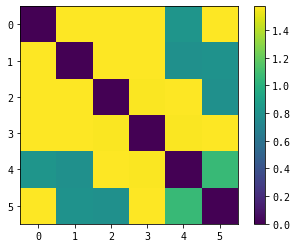

In [107]:
plt.colorbar(plt.imshow(angles))

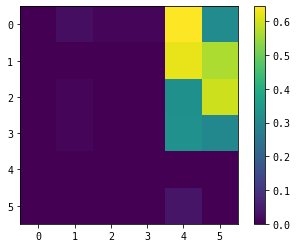

In [109]:
plt_img = plt.imshow(alphas)
plt.colorbar(plt_img)

In [96]:
p_index = get_prop_index(distribs)
alphas = -np.log(p_index, where=(0 < p_index) & (p_index < 1), out=np.full_like(p_index, np.infty))
alphas = variance_diffs / alphas

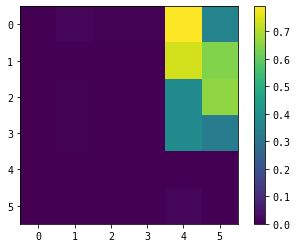

In [98]:
plt_img = plt.imshow(alphas)
plt.colorbar(plt_img)